# TOP BOTTOM - CHURN PROJECT

# Ciclo 00 - Metodo IOT

## Input

### O problema de negócio

1. Recorrencia de compra baixa.
2. Clientes deixando de comprar apos determinado periodo.

## Output

1. Qual a taxa de Churn atual da empresa?
2. Como a taxa de churn varia por mes?
3. Qual retorno esperado em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn?
4. Qual a performance do modelo em classificar os clientes como churns?



## Tasks

1. Qual a taxa de Churn atual da empresa?
    - Anual, semestral ou mensal.
    - Se 1 de cada 20 clientes cancelam seu produto todo mês, isso representa que a taxa de churn para seu produto será de 5%.
    - Encontrar churn rate e fazer o churn mensal.

2. Como a taxa de churn varia por mes?
    - Calcular o churn mensal.
    - MRR CHURN = SUM (MRR dos clientes cancelados)

3.Qual retorno esperado em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn?
 - se esse cliente for recuperado quanto ele me traz baseado no salario
     - threshold
     - lista de pessoas que vao entrar em churn ordenada
     - quais pessoas recuperar
     - LTV
     - curva Roc (live 21)

4. Qual a performance do modelo em classificar os clientes como churns?
    - Mostrar Recall, Precision e Acc.
    - Procurar diferentes metricas de reporte.
    - fazer o score



## Etapa 01 - Descrição dos dados: 
   - O objetivo é utilizar métricas estatísticas para identificar outliers no escopo do negócio.

## Etapa 02 - Feature Engineering:
   - Derivar novos atributos com base nas variáveis ​​originais para melhor descrever o fenômeno a ser modelado.

## Etapa 03 - Filtragem de Dados: 
- Filtrar as linhas e selecione as colunas que não contenham informações para modelagem ou que não correspondam ao escopo do negócio.

## Etapa 04 - Análise Exploratória de Dados: 
- Explorar os dados para encontrar insights e entender melhor o impacto das variáveis ​​no aprendizado do modelo.

## Etapa 05 - Preparação de dados: 
- Preparar os dados para que os modelos de aprendizado de máquina possam aprender comportamentos específicos.

## Etapa 06 - Seleção de atributos: 
- Seleção dos atributos mais significativos para treinar o modelo.

## Etapa 07 - Machine Learning Modeling: 
-Treinamento do modelo de aprendizado de máquina

## Passo 08 -  Hyperparameter Fine Tunning:
- Escolha os melhores valores para cada um dos parâmetros do modelo selecionado no passo anterior.

## Etapa 09 - Converter o desempenho do modelo em valores de negócios: 
- Converter o desempenho do modelo em resultado de negócios.

## Etapa 10 - Implantar o modelo na produção: 
- Publique o modelo em um ambiente de nuvem para que outras pessoas ou serviços possam usar os resultados para melhorar a decisão de negócios.

# 0.0 IMPORTS

In [42]:
import shap 
import pickle
import warnings
import inflection

import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import matplotlib.pyplot       as plt

from yellowbrick.classifier    import ConfusionMatrix, ROCAUC
from IPython.core.display      import HTML
from sklearn                   import preprocessing
from sklearn.preprocessing     import RobustScaler,StandardScaler, MinMaxScaler
from sklearn                   import model_selection    as ms
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LogisticRegression

from boruta                    import BorutaPy
from BorutaShap                import BorutaShap
from scipy.stats               import chi2_contingency,shapiro
from sklearn.metrics           import accuracy_score, classification_report


from imblearn                  import under_sampling as us
from imblearn                  import over_sampling  as oversamp
from imblearn                  import combine        as c
from imblearn.over_sampling    import KMeansSMOTE as ksmt
from catboost                  import CatBoostClassifier, Pool




from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn                   import neighbors          as nh
from sklearn.naive_bayes import GaussianNB
import xgboost                 as xgb
from yellowbrick.contrib.wrapper import wrap
import scikitplot              as skplt



##  Helper Functions

In [43]:


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()
warnings.filterwarnings("ignore")


#Function to plot correlation of a column 
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Greens').set_title(col);
    
    return plot

# cramer V function to calculate correlation btw categorical variables
def cramer_v(x, y):
    # Confusion Matrix
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


##  Get Data from Database

##  Load dataset

In [44]:
df_raw=pd.read_csv('/home/tc0019/DS/topbottom/churn.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#  1.0 DESCRICAO DOS DADOS

In [45]:
df1=df_raw.copy()

## 1.1. Rename Columns

All columns will be renamed to snake case: https://en.wikipedia.org/wiki/Snake_case.

The main objective is create a columns name pattern to make simple dealing with the dataset.

In [46]:
df1.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [47]:
cols_old=['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimensions

In [48]:
print( f'Number of Rows: {df1.shape[0]}')
print( f'Number of Columns: {df1.shape[1]}')

Number of Rows: 10000
Number of Columns: 14


## 1.3. Data Types

In [49]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

In [50]:
df1.tail()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


## 1.4. Check NA

 The dataset has no occurrence of NAs

In [51]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Descriptive Statistics

In [52]:
df1_num=df1.select_dtypes(include=['int64', 'float64'])
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### 1.5.1. Numerical Atributes

In [53]:
# Central Tendency - mean, meadina
ct1= pd.DataFrame(df1_num.apply(np.mean)).T
ct2= pd.DataFrame(df1_num.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
ct3= pd.DataFrame(df1_num.apply(np.std)).T
ct4= pd.DataFrame(df1_num.apply(min)).T
ct5= pd.DataFrame(df1_num.apply(max)).T
ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T


# concatenar
df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8, ct9]).T
df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
df_statistics.round(2)

,min,max,range,mean,median,std,skew,kurtosis,shapiro
row_number,1.0,10000.0,9999.0,5000.5,5000.5,2886.751332,0.0,-1.2,not normal
customer_id,15565701.0,15815690.0,249989.0,15690940.5694,15690738.0,71932.589224,0.001149,-1.196113,not normal
credit_score,350.0,850.0,500.0,650.5288,652.0,96.648466,-0.071607,-0.425726,not normal
age,18.0,92.0,74.0,38.9218,37.0,10.487282,1.01132,1.395347,not normal
tenure,0.0,10.0,10.0,5.0128,5.0,2.89203,0.010991,-1.165225,not normal
balance,0.0,250898.09,250898.09,76485.889288,97198.54,62394.285254,-0.141109,-1.489412,not normal
num_of_products,1.0,4.0,3.0,1.5302,1.0,0.581625,0.745568,0.582981,not normal
has_cr_card,0.0,1.0,1.0,0.7055,1.0,0.455818,-0.901812,-1.186973,not normal
is_active_member,0.0,1.0,1.0,0.5151,1.0,0.499772,-0.060437,-1.996747,not normal
estimated_salary,11.58,199992.48,199980.9,100090.239881,100193.915,57507.617221,0.002085,-1.181518,not normal


**Relavants Observations:**

**credit_score** may be better work in a categorical way to group people in classes

**estimated_salary** will be considered as annual salary, the value 11.50 must be checked it may be an input error.

**none** of the features have normal distribution

### 1.5.2 Categorical Attributes

**Gender** do not show to be a significant attribute to consider churn

**Geography** has similar churn, nothing seems to extrapolate due geo.

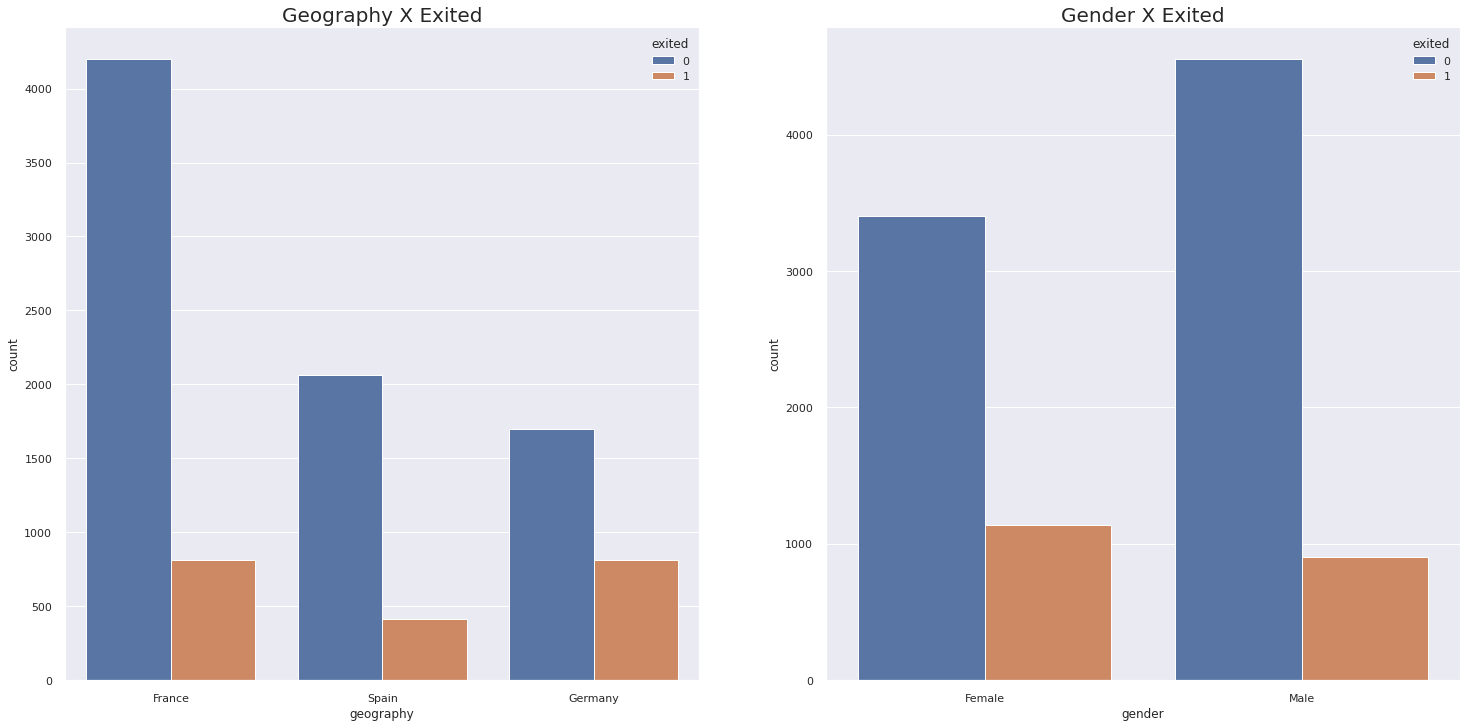

In [54]:
plt.subplot(1,2,1)
sns.countplot(x='geography', hue='exited', data=df1).set_title('Geography X Exited', fontsize=20);

plt.subplot(1,2,2)
sns.countplot(x='gender', hue='exited', data=df1).set_title('Gender X Exited', fontsize=20);



### 1.5.3 Target Variable

The dataset is unbalanced. Smote Tomek may be used here.

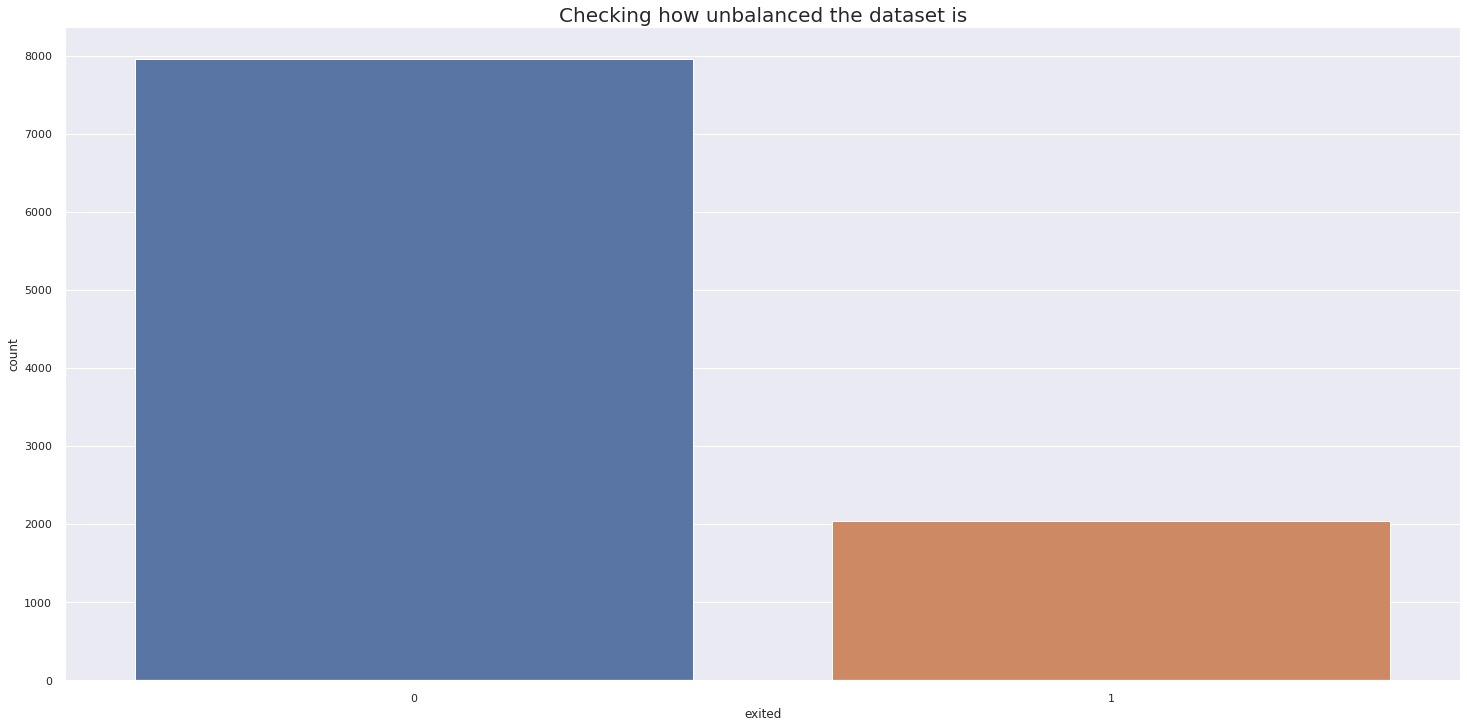

In [55]:
sns.countplot(x='exited', data=df1).set_title('Checking how unbalanced the dataset is', fontsize=20);

# 2.0 FEATURE ENGINEERING

In [56]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map

###  2.1.1 Hypotheses List

1. Os usuarios com score maior que 800 tem mais dinheiro em media. 
2. A espanha possue o maior numero de cartoes de credito da base de dados.
3. O publico feminino possui o score maior do que o masculino. 
4. Homens possuem mais dinheiro do que mulheres no banco.
5. O salario estimados das mulherem em media eh maior do que dos homens.
6. Pessoas que moram na alemanha em media sao mais ativos que os demais.
7. Os clientes com cadastro ativo sao maioria mulheres. 
8. Os clientes com maior numero de tenure comprados sao os que tem o menor salario estiamdo.
9. Pessoas que possuem cartao sao mais ativas do que as que nao possuem mais.
10. Salarios acima de 80k permanecem em media 3 anos.
11. Os alemaes possuem o maior salario da base.
12. Pessoas com balancos superior a 70k sao menos propensas ao churn.
13. Pessoas com score superior a 780 nao deixam a empresa.
14. Pessoas da franca entram sao mais propensos a entrar em churn do que as demais.
15. Homens entram em churn mais do que mulheres.
16. Pessoas acima dos 35 sao mais propensas a sairem da empresa.
17. Homens acima 40 anos e sem atividade no site sao mais propensos ao churn.
18. Mulheres abaixo dos 30 anos tem 70% de chance de NAO abandonar a empresa.
19. Homens com 40 anos e sem atividade no site sao mais propensos ao churn.
20. Mulheres com score acima dos 800 e balance acima de 80k tem 90% de NAO abandonar a empresa.
21. Pessoas com tenure acima de 8 tem 60% de pessoas ativa no site.



###  2.1.2 Hypotheses Final List

1. Os usuarios com score maior que 800 em media tem mais dinheiro no banco.
2. A espanha possue o maior numero de cartoes de credito da base de dados.
3. O publico feminino possui o score maior do que o masculino. 
4. Homens possuem mais dinheiro do que mulheres no banco.
5. O salario estimados das mulherem em media eh maior do que dos homens.
6. Pessoas que moram na alemanha em media sao mais ativos que os demais.


## 2.2 Feature Engineering

In [57]:
# df2['credit_score']=df2['credit_score'].apply(lambda x: 'poor' if x <=200 else
#                                                         'fair' if x in range(201, 400) else
#                                                         'good' if x in range(401, 600) else
#                                                         'great' if x in range(601, 800)
#                                                         else 'awesome'
#                                                          )


df2['balance_by_age']=df2['balance']/df2['age']
df2['num_of_prod_by_age']=df2['num_of_products']/df2['age']
df2['balance_by_num_of_prod']=df2['balance']/df2['num_of_products']

df2.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,balance_by_age,num_of_prod_by_age,balance_by_num_of_prod
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.023810,0.000000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2044.094146,0.024390,83807.860000
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3801.447619,0.071429,53220.266667
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.051282,0.000000
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2918.856279,0.023256,125510.820000
